In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step2 Calculating RFM Score

In [2]:
# 1. Construct the file path dynamically
# '..' means go up one level, enter 'data' folder, and find 'online_retail_II_cleaned.csv'
file_path = os.path.join('..', 'data', 'online_retail_II_cleaned.csv')

# 2. Read the CSV file
try:
    df_clean = pd.read_csv(file_path, encoding='utf-8')
    
    # --- CRITICAL STEP ---
    # When reading from CSV, dates are read as strings (object). 
    # We MUST convert them back to datetime objects for date calculations (like Recency) to work.
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    print(f"Data loaded successfully: {file_path}")
    print(df_clean.info()) # Check the data types again
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print(f"Current working directory: {os.getcwd()}")

Data loaded successfully: ..\data\online_retail_II_cleaned.csv
<class 'pandas.DataFrame'>
RangeIndex: 776637 entries, 0 to 776636
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      776637 non-null  int64         
 1   StockCode    776637 non-null  str           
 2   Description  776637 non-null  str           
 3   Quantity     776637 non-null  float64       
 4   InvoiceDate  776637 non-null  datetime64[us]
 5   Price        776637 non-null  float64       
 6   Customer ID  776637 non-null  int64         
 7   Country      776637 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(2), str(3)
memory usage: 47.4 MB
None


In [3]:
from datetime import timedelta

df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

if 'df_clean' in locals() and 'TotalPrice' in df_clean.columns:
    print(f"--- 12. Calculating RFM Metrics ---")
    
    # --- 1. Define the 'Snapshot Date' ('Today') ---
    # Standard practice is to take the max date in the dataset + 1 day
    # This ensures even the most recent customer has Recency >= 1 day
    snapshot_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
    
    print(f"Snapshot Date (Our 'Today') set to: {snapshot_date.date()}")
    
    # --- 2. Aggregate Data to Customer Level (RFM) ---
    # We use .agg() for a single, efficient pass over the data
    
    try:
        rfm_df = df_clean.groupby('Customer ID').agg(
            
            # R (Recency): (Snapshot Date) - (Customer's Last Purchase Date)
            # We get the .days attribute from the resulting Timedelta
            Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
            
            # F (Frequency): Count of unique Invoices
            Frequency = ('Invoice', 'nunique'),
            
            # M (Monetary): Sum of TotalPrice for all transactions
            Monetary = ('TotalPrice', 'sum')
            
        ).reset_index() # .reset_index() makes 'Customer ID' a column (optional, but cleaner)

        print(f"\nRFM calculation complete.")
        
        # --- 3. Display the new 'RFM' DataFrame ---
        print(f"Created rfm_df with shape: {rfm_df.shape}")
        print("\n--- RFM DataFrame (Head) ---")
        print(rfm_df.head())
        
    except Exception as e:
        print(f"Error during RFM aggregation: {e}")

else:
    print("Error: 'df_clean' DataFrame (or 'TotalPrice' column) not found.")

--- 12. Calculating RFM Metrics ---
Snapshot Date (Our 'Today') set to: 2011-12-10

RFM calculation complete.
Created rfm_df with shape: (5853, 4)

--- RFM DataFrame (Head) ---
   Customer ID  Recency  Frequency  Monetary
0        12346      326          3  77352.96
1        12347        2          8   4921.53
2        12348       75          5   1658.40
3        12349       19          3   3678.69
4        12350      310          1    294.40


## IQR Outlier Removal

--- Outlier Detection and Removal ---
Generating Boxplots to visualize outliers...

Cleaning outliers using the 1.5 * IQR rule...
Row count before cleaning: 5853
Cleaning 'Recency': Removing values < -506.00 or > 910.00
Cleaning 'Frequency': Removing values < -8.00 or > 16.00
Cleaning 'Monetary': Removing values < -1850.88 or > 3934.08

Number of VIP customers retained after cleaning: 380

Cleaning complete.
Row count after cleaning: 4982
Total rows removed (outliers): 871

--- Cleaned RFM Statistics (Describe) ---
        Customer ID      Recency    Frequency     Monetary
count   4982.000000  4982.000000  4982.000000  4982.000000
mean   15342.639703   225.193898     3.460658   986.543822
std     1701.807126   211.957662     2.943618   915.630994
min    12348.000000     1.000000     1.000000     0.000000
25%    13861.250000    36.000000     1.000000   301.375000
50%    15351.500000   149.000000     2.000000   661.355000
75%    16808.750000   396.000000     5.000000  1398.340000
max    

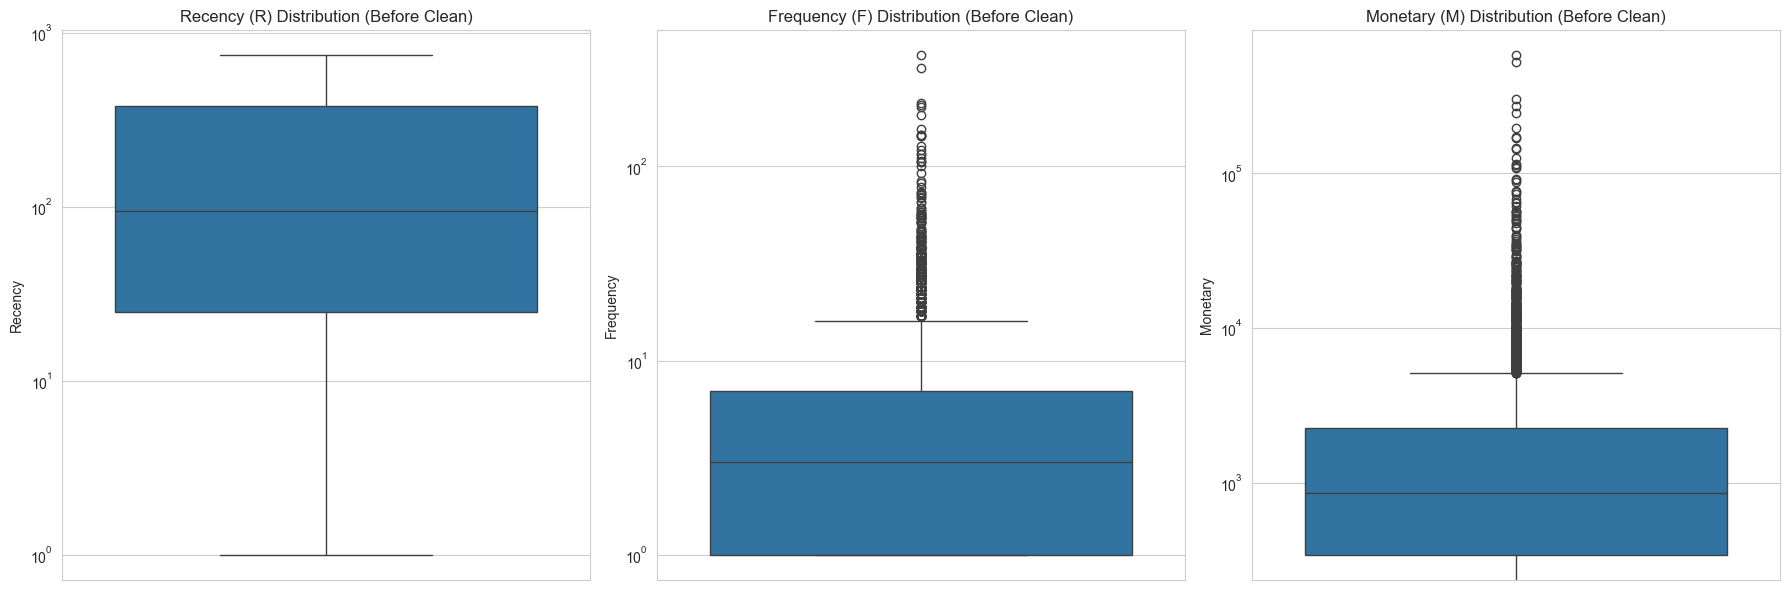

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'rfm_df' in locals():
    print(f"--- Outlier Detection and Removal ---")
    
    # ---  Visualize Outliers (The 'Ward') ---
    print("Generating Boxplots to visualize outliers...")
    
    # Set the style
    sns.set_style("whitegrid")
    
    # Create a 1x3 figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot R (Recency)
    sns.boxplot(y=rfm_df['Recency'], ax=axes[0])
    axes[0].set_title('Recency (R) Distribution (Before Clean)')
    axes[0].set_yscale('log') # Use log scale if R is heavily skewed
    
    # Plot F (Frequency)
    sns.boxplot(y=rfm_df['Frequency'], ax=axes[1])
    axes[1].set_title('Frequency (F) Distribution (Before Clean)')
    axes[1].set_yscale('log') # Use log scale if F is heavily skewed
    
    # Plot M (Monetary)
    sns.boxplot(y=rfm_df['Monetary'], ax=axes[2])
    axes[2].set_title('Monetary (M) Distribution (Before Clean)')
    axes[2].set_yscale('log') # Use log scale if M is heavily skewed
    
    plt.tight_layout()
    
    # ---  Clean Outliers using IQR (The 'Gank') ---
    print("\nCleaning outliers using the 1.5 * IQR rule...")
    
    rows_before = rfm_df.shape[0]
    print(f"Row count before cleaning: {rows_before}")
    
    # Create a new DataFrame for the cleaned data
    rfm_cleaned = rfm_df.copy()
    
    # We apply the IQR rule to R, F, and M, and count VIP customers
    vip_ID = set(rfm_df['Customer ID'])
    for col in ['Recency', 'Frequency', 'Monetary']:
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = rfm_cleaned[col].quantile(0.25)
        Q3 = rfm_cleaned[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define the upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"Cleaning '{col}': Removing values < {lower_bound:.2f} or > {upper_bound:.2f}")

        if col == 'Monetary':
            # Count VIP customers above the upper bound
            vip_customers = rfm_df[rfm_df[col] > upper_bound]
            vip_ID = vip_ID.intersection(set(vip_customers['Customer ID']))
        elif col == 'Frequency':
            # Count VIP customers above the upper bound
            vip_customers = rfm_df[rfm_df[col] > upper_bound]
            vip_ID = vip_ID.intersection(set(vip_customers['Customer ID']))
        elif col == 'Recency':
            # Count VIP customers below the average of bounds
            vip_customers = rfm_df[rfm_df[col] < (upper_bound + lower_bound)/2]
            vip_ID = vip_ID.intersection(set(vip_customers['Customer ID']))

        # Filter the DataFrame
        rfm_cleaned = rfm_cleaned[
            (rfm_cleaned[col] >= lower_bound) & 
            (rfm_cleaned[col] <= upper_bound)
        ]
    print(f"\nNumber of VIP customers retained after cleaning: {len(vip_ID)}")
    
    # ---  Check Results ---
    rows_after = rfm_cleaned.shape[0]
    rows_removed = rows_before - rows_after
    
    print(f"\nCleaning complete.")
    print(f"Row count after cleaning: {rows_after}")
    print(f"Total rows removed (outliers): {rows_removed}")
    
    print("\n--- Cleaned RFM Statistics (Describe) ---")
    print(rfm_cleaned.describe())
    
else:
    print("Error: 'rfm_df' DataFrame not found.")
    print("Please run the RFM calculation first.")

In [5]:
# # Log Transformation
# for col in ['Recency', 'Frequency', 'Monetary']:
#     # Apply log1p transformation
#     rfm_cleaned[col] = rfm_cleaned[col].apply(lambda x: np.log1p(x))
#     rfm_cleaned[col] = rfm_cleaned[col].replace(-np.inf, 0)

## Normalize RFM data

In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize RFM data
if 'rfm_cleaned' in locals():
    print(f"--- Normalizing RFM Data ---")
    # Create a copy of the cleaned RFM data for scaling
    rfm_scaled = rfm_cleaned.copy()
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    scaler.fit(rfm_cleaned[['Recency', 'Frequency', 'Monetary']])
    
    # Fit and transform the RFM columns (Recency, Frequency, Monetary)
    rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
        rfm_scaled[['Recency', 'Frequency', 'Monetary']]
    )
    
    print("RFM data scaled successfully.")
    
    print("\n--- Scaled RFM Data (Head) ---")
    print(rfm_scaled.head())

--- Normalizing RFM Data ---
RFM data scaled successfully.

--- Scaled RFM Data (Head) ---
   Customer ID   Recency  Frequency  Monetary
2        12348 -0.708674   0.522995  0.733837
3        12349 -0.972905  -0.156510  2.940504
4        12350  0.400149  -0.836014 -0.755996
5        12351  0.706845  -0.836014 -0.748864
6        12352 -0.892692   1.882003  0.811540


# Step3 K-Means Clustering

## Elbow Method

--- Elbow Method to Determine Optimal Clusters ---
Calculating WCSS for K values from 1 to 10...


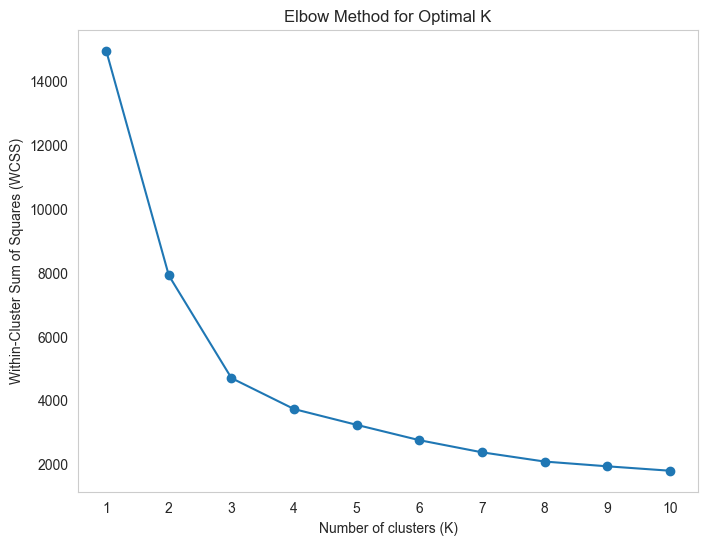

According to the Elbow Method, the optimal number of clusters is 4.


In [7]:
# Elbow Method to Determine Optimal Clusters
print(f"--- Elbow Method to Determine Optimal Clusters ---")
print("Calculating WCSS for K values from 1 to 10...")

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=42)
    kmeans.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid()
plt.show()

print("According to the Elbow Method, the optimal number of clusters is 4.")


## Apply K-Means

In [8]:
# Apply KMeans Clustering with K=4
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k,
                      init='k-means++',
                      max_iter=300,
                      n_init=10,
                      random_state=42)
kmeans_final.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
# Assign cluster labels to the scaled RFM data
rfm_scaled['KM_Cluster'] = kmeans_final.labels_

# Display cluster counts and cluster centers
cluster_counts = rfm_scaled['KM_Cluster'].value_counts().sort_index()
cluster_centers = pd.DataFrame(kmeans_final.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
print("\n--- Cluster Counts and its Centers ---")
for cluster_num in range(optimal_k):
    count = cluster_counts[cluster_num]
    center = cluster_centers.loc[cluster_num].to_dict()
    print(f"{cluster_num}: Count = {count}, Center = {center}")


--- Cluster Counts and its Centers ---
0: Count = 1715, Center = {'Recency': -0.6061347302448504, 'Frequency': -0.4698675155439462, 'Monetary': -0.5194224195505157}
1: Count = 563, Center = {'Recency': -0.7547038926010545, 'Frequency': 2.101275850370386, 'Monetary': 1.9730552796972767}
2: Count = 1621, Center = {'Recency': 1.23554976096573, 'Frequency': -0.6093028025642946, 'Monetary': -0.5922532120475291}
3: Count = 1083, Center = {'Recency': -0.4956123012507398, 'Frequency': 0.5583463601809342, 'Monetary': 0.6776226593353745}


In [9]:
# --- Restore Cluster Centers to Original Scale ---
print("--- Restoring Cluster Centers to Original (Un-normalized) Values ---")
original_centers = scaler.inverse_transform(cluster_centers)
original_centers_df = pd.DataFrame(original_centers, columns=['Recency', 'Frequency', 'Monetary'])
print(original_centers_df)  

# Count VIPs RFM data
vip_df = rfm_df[rfm_df['Customer ID'].isin(vip_ID)]
vip_RFM = {
    'Recency': vip_df['Recency'].mean(),
    'Frequency': vip_df['Frequency'].mean(),
    'Monetary': vip_df['Monetary'].mean()
}
vip_RFM = pd.DataFrame([vip_RFM])
print("\n--- VIP Customers RFM Counts ---")
print(vip_RFM)

--- Restoring Cluster Centers to Original (Un-normalized) Values ---
      Recency  Frequency     Monetary
0   96.731893   2.077687   510.992290
1   65.244681   9.645390  2792.953067
2  487.051852   1.667284   444.312852
3  120.155617   5.104052  1606.933858

--- VIP Customers RFM Counts ---
     Recency  Frequency      Monetary
0  19.176316  35.713158  22067.608711


## Final Result

In [10]:
import pandas as pd
import numpy as np

# --- Step 1: Define the data we calculated ---

centers_data = {
    'Recency': [96.73, 65.24, 487.05, 120.16],
    'Frequency': [2.08, 9.65, 1.67, 5.10],
    'Monetary': [510.99, 2792.95, 444.31, 1606.93]
}
original_centers_df = pd.DataFrame(centers_data, index=[0, 1, 2, 3])
original_centers_df.index.name = 'Cluster_ID'

counts_data = {
    0: 1715,
    1: 563,
    2: 1621,
    3: 1083
}
cluster_counts = pd.Series(counts_data, name='Count')
cluster_counts.index.name = 'Cluster_ID'

vip_data = {
    'Cluster_ID': -1,
    'Count': 380, 
    'Recency': 19.18, 
    'Frequency': 35.71, 
    'Monetary': 22067.61
}
vip_df = pd.DataFrame(vip_data, index=[-1])
vip_df = vip_df.set_index('Cluster_ID')


# --- Step 2: Combine K-Means table and VIP table ---
summary_table_kmeans = pd.concat([cluster_counts, original_centers_df], axis=1)
summary_table_final = pd.concat([summary_table_kmeans, vip_df])


# --- Step 3: Add User Profiles ---
# Now we re-assign profiles based on this complete table
profile_map_en = {
    -1: ' TOP VIP ',
    0: ' New / Low-Value',
    1: ' High-Value Customer', 
    2: ' At-Risk / Churned',
    3: ' Loyal Customer'
}
summary_table_final['User_Profile'] = summary_table_final.index.map(profile_map_en)

# --- Step 4: Format and Print (Sorted by Monetary) ---
summary_table_final = summary_table_final.sort_values(by='Monetary', ascending=False)

# Re-order columns
summary_table_final = summary_table_final[['Count', 'Recency', 'Frequency', 'Monetary', 'User_Profile']]

print("\n======================================================================")
print("        FINAL Cluster Analysis Summary (with TOP VIPs) ")
print("======================================================================")
# Print the final formatted table
print(summary_table_final)


        FINAL Cluster Analysis Summary (with TOP VIPs) 
            Count  Recency  Frequency  Monetary          User_Profile
Cluster_ID                                                           
-1            380    19.18      35.71  22067.61              TOP VIP 
 1            563    65.24       9.65   2792.95   High-Value Customer
 3           1083   120.16       5.10   1606.93        Loyal Customer
 0           1715    96.73       2.08    510.99       New / Low-Value
 2           1621   487.05       1.67    444.31     At-Risk / Churned


## Visualize Clusters

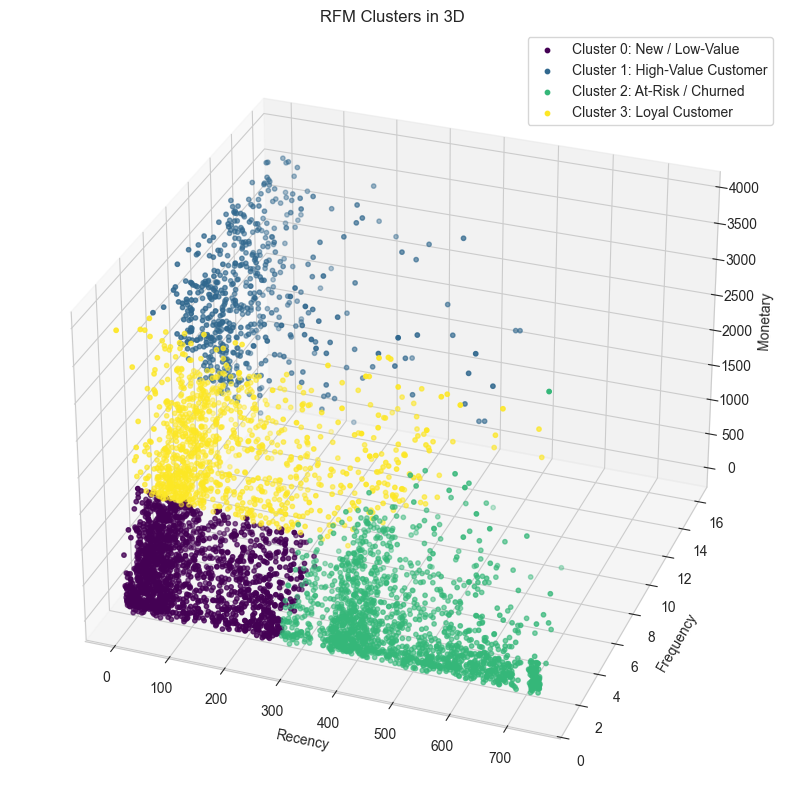

In [11]:
# Visualize Clusters in 3D with Legend
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plot_df = rfm_cleaned.copy()
plot_df['KM_Cluster'] = rfm_scaled['KM_Cluster']

profile_map_for_plot = {
    0: 'New / Low-Value',
    1: 'High-Value Customer',
    2: 'At-Risk / Churned',
    3: 'Loyal Customer'
}

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('viridis') 

colors = cmap(np.linspace(0, 1, len(profile_map_for_plot)))

for cluster_id, profile_name in profile_map_for_plot.items():

    cluster_data = plot_df[plot_df['KM_Cluster'] == cluster_id]
    
    ax.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               cluster_data['Monetary'],
               c=[colors[cluster_id]], 
               label=f'Cluster {cluster_id}: {profile_name}', 
               s=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Clusters in 3D ')
ax.view_init(elev=30, azim=-70)
ax.legend()

plt.show()

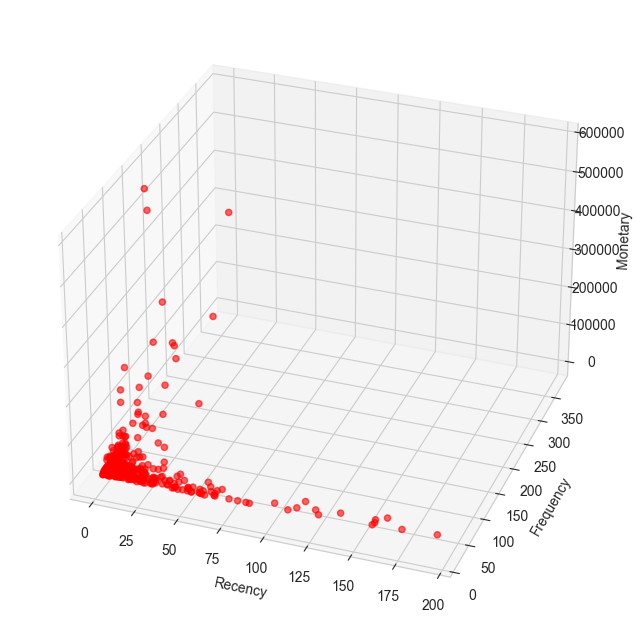

In [12]:
# Visualization VIP Customers distribution
vip_customers_df = rfm_df[rfm_df['Customer ID'].isin(vip_ID)]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.view_init(elev=30, azim=-70)
ax.scatter(vip_customers_df['Recency'], vip_customers_df['Frequency'], vip_customers_df['Monetary'],
           c='red', label='VIP Customers', alpha=0.6, s=20)

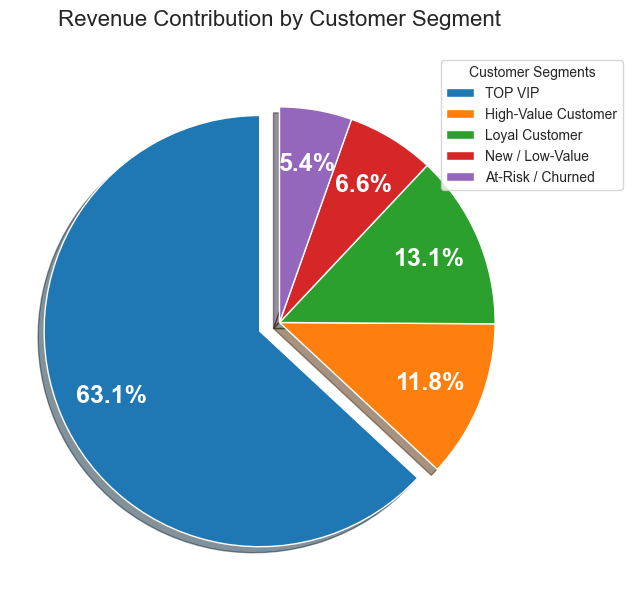

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Prepare Data ---
# This recreates the summary table from your previous cells,
# allowing this code block to run independently.
summary_data = {
    'Count': [380, 563, 1083, 1715, 1621],
    'Recency': [19.18, 65.24, 120.16, 96.73, 487.05],
    'Frequency': [35.71, 9.65, 5.10, 2.08, 1.67],
    'Monetary': [22067.61, 2792.95, 1606.93, 510.99, 444.31],
    'User_Profile': ['TOP VIP', 'High-Value Customer', 'Loyal Customer', 'New / Low-Value', 'At-Risk / Churned']
}
summary_table_final = pd.DataFrame(summary_data)

# --- 2. Calculate Total Revenue Contribution ---
# Contribution = Number of Customers * Average Monetary Value for the segment
summary_table_final['Total_Contribution'] = summary_table_final['Count'] * summary_table_final['Monetary']

# --- 3. Prepare Data for Plotting ---
labels = summary_table_final['User_Profile']
sizes = summary_table_final['Total_Contribution']
# The "explode" parameter is used to highlight a slice. Here, we highlight the 'TOP VIP' segment.
explode = (0.1, 0, 0, 0, 0)  # Explode the first slice (TOP VIP)

# --- 4. Create the 3D Pie Chart ---
# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 7))

# Draw the pie chart. The 'shadow=True' parameter adds a shadow to create a 3D effect.
wedges, texts, autotexts = ax.pie(sizes, 
                                  explode=explode, 
                                  labels=None,  # Labels will be shown in the legend
                                  autopct='%1.1f%%',
                                  shadow=True, 
                                  startangle=90, # Rotate the chart to a better angle
                                  pctdistance=0.75) # Position of the percentage text


# --- 6. Add Title and Legend ---
# Set the chart title
ax.set_title("Revenue Contribution by Customer Segment", fontsize=16, pad=20)

# Add a legend in the 'upper right' corner of the plot area
ax.legend(wedges, 
          labels,
          title="Customer Segments",
          loc="upper right",
          bbox_to_anchor=(1.15, 1)) # Adjust bbox to position the legend neatly

# --- 7. Final Touches ---
# Customize the percentage text style
plt.setp(autotexts, size=18, weight="bold", color="white")

# Display the plot
plt.show()

# Bussiness Analysis

## Retention analysis

In [14]:
## Retention analysis
import datetime as dt

# 1. ensure correct time format 
# assume 'InvoiceDate', ID called 'Customer ID'
df_cohort = df_clean.copy()
# extract year-month, e.g., 2010-01-01
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].apply(get_month)

# 2. find each user's "birth month" (CohortMonth)
grouping = df_cohort.groupby('Customer ID')['InvoiceMonth']
df_cohort['CohortMonth'] = grouping.transform('min')

# 3. calculate time difference (CohortIndex) - which month they retained
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(df_cohort, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df_cohort, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# Index = 1 means the same month, Index = 2 means retained in the next month...
df_cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

# 4. calculate how many users remain in each group each month
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_data.rename(columns={'Customer ID': 'UserCount'}, inplace=True)

# 5. calculate retention rate
# first get the total number of users in each cohort (baseline)
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UserCount')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# 6. key step: unpivot/melt the table! Power BI prefers long tables over wide tables
# reset index to turn it into a regular column
retention_reset = retention.reset_index()
# Melt the DataFrame
cohort_for_pbi = retention_reset.melt(id_vars=['CohortMonth'], var_name='Month_Index', value_name='Retention_Rate')

# 7. export to CSV for Power BI
output_dir = os.path.join('..', 'data')

# Create the directory if it doesn't exist (optional, but good practice)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'cohort_data_for_pbi.csv')

cohort_for_pbi.to_csv(output_path, index=False, encoding='utf-8')
print("Retention data exported: cohort_data_for_pbi.csv")
print(cohort_for_pbi.head())

Retention data exported: cohort_data_for_pbi.csv
  CohortMonth Month_Index  Retention_Rate
0  2009-12-01           1             1.0
1  2010-01-01           1             1.0
2  2010-02-01           1             1.0
3  2010-03-01           1             1.0
4  2010-04-01           1             1.0


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

profile_map_en = {
    -1: 'TOP VIP',
    0:  'New / Low-Value',
    1:  'High-Value Customer',
    2:  'At-Risk / Churned',
    3:  'Loyal Customer'
}

# ==========================================
    # Function to process segmentation for a given period
    # ==========================================
def process_segmentation(df_input, period_name):
    print(f"--- Processing Period: {period_name} ---")
    
    # 1. calculate RFM
    now_date = df_input['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm = df_input.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (now_date - x.max()).days,
        'Invoice': 'nunique',
        'Price': lambda x: (x * df_input.loc[x.index, 'Quantity']).sum()
    }).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Price': 'Monetary'})
    
    rfm = rfm[rfm['Monetary'] > 0]  # filter out negative or zero monetary values
    
    # 2. VIP selection (reuse your IQR logic)
    vip_indices = set()
    # calculate IQR
    Q1 = rfm.quantile(0.25)
    Q3 = rfm.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Strict VIP rule: High M AND High F AND Low R
    vips = rfm[
        (rfm['Monetary'] > upper['Monetary']) & 
        (rfm['Frequency'] > upper['Frequency']) & 
        (rfm['Recency'] < (upper['Recency'] + lower['Recency'])/2)
    ]
    vip_indices = vips.index
    
    print(f"  > Identified {len(vip_indices)} TOP VIPs (Label -1)")

    # 3. Prepare K-Means data
    # Remove extreme outliers from the remaining data for model stability,
    # but predict for all users in the end
    non_vip_rfm = rfm.drop(vip_indices)
    
    # Define core data (within IQR range) for training K-Means
    core_mask = (
        (non_vip_rfm['Recency'] >= lower['Recency']) & (non_vip_rfm['Recency'] <= upper['Recency']) &
        (non_vip_rfm['Frequency'] >= lower['Frequency']) & (non_vip_rfm['Frequency'] <= upper['Frequency']) &
        (non_vip_rfm['Monetary'] >= lower['Monetary']) & (non_vip_rfm['Monetary'] <= upper['Monetary'])
    )
    rfm_core = non_vip_rfm[core_mask]
    
    # 4. K-Means training
    # Log Transform & Scale
    rfm_core_log = np.log1p(rfm_core)
    scaler = StandardScaler()
    rfm_core_scaled = scaler.fit_transform(rfm_core_log)
    
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(rfm_core_scaled)
    
    # 5. Dynamic label alignment (to prevent Label Drift)
    # We need to analyze the features of these 4 clusters and map them to 0, 1, 2, 3
    cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['R','F','M'])
    cluster_centers['temp_label'] = range(4)
    
    # Mapping logic (based on your Table 2 features):
    # Cluster 2 (At-Risk): The one with the highest Recency
    label_2_idx = cluster_centers.sort_values('R', ascending=False).iloc[0]['temp_label']
    
    # Remaining 3 clusters
    remaining = cluster_centers[cluster_centers['temp_label'] != label_2_idx].copy()
    
    # Cluster 0 (New/Low): The one with the lowest Monetary
    label_0_idx = remaining.sort_values('M', ascending=True).iloc[0]['temp_label']
    
    # Cluster 1 (High-Value): The one with the highest Monetary
    label_1_idx = remaining.sort_values('M', ascending=False).iloc[0]['temp_label']
    
    # Cluster 3 (Loyal): The remaining one
    label_3_idx = [x for x in remaining['temp_label'] if x not in [label_0_idx, label_1_idx]][0]
    
    # Build mapping dictionary
    map_dict = {
        label_0_idx: 0,
        label_1_idx: 1,
        label_2_idx: 2,
        label_3_idx: 3
    }
    
    print(f"  > Label Mapping Logic: {map_dict}")
    
    # 6. Predict for all non-VIP users (including core and outliers)
    # This ensures user_id is not lost
    non_vip_log = np.log1p(non_vip_rfm)
    non_vip_scaled = scaler.transform(non_vip_log)
    raw_labels = kmeans.predict(non_vip_scaled)
    
    # Apply mapping
    final_labels = [map_dict[x] for x in raw_labels]
    non_vip_rfm['Segment_Code'] = final_labels
    
    # 7. Merge results
    # VIPs set to -1
    rfm.loc[vip_indices, 'Segment_Code'] = -1
    # Non-VIPs filled with calculated labels
    rfm.loc[non_vip_rfm.index, 'Segment_Code'] = non_vip_rfm['Segment_Code']
    
    return rfm[['Segment_Code']]

# ==========================================
# Main program: Execute two years split
# ==========================================
# Assume df_clean is your original cleaned data
split_date = pd.to_datetime('2010-12-01')
df_2010 = df_clean[df_clean['InvoiceDate'] < split_date]
df_2011 = df_clean[df_clean['InvoiceDate'] >= split_date]

# Process separately
res_2010 = process_segmentation(df_2010, "2010")
res_2011 = process_segmentation(df_2011, "2011")

# ==========================================
# Generate final table (Join)
# ==========================================
migration = res_2010.join(res_2011, lsuffix='_2010', rsuffix='_2011', how='outer')

# 填补空值 (New / Lost)
# 我们可以给 New/Lost 赋予特殊的 Code，比如 -99 和 -88，或者直接填字符串
# 这里为了方便 Power BI 处理，先填 Code，你可以自己在 PBI 里改名
# 假设：New = 0 (归入 New/Low-Value 或者单独一类), Lost = 2 (归入 At-Risk 或者单独一类)
# 建议：为了桑基图清晰，这里直接填 Code，保留 NaN 也可以让 PBI 处理
# 这里我们保留 Segment Code

migration_final = migration.reset_index()

# 映射成文字名称 (这一步做完，Power BI 直接用 strings 画图更方便)
migration_final['Segment_2010_Name'] = migration_final['Segment_Code_2010'].map(profile_map_en).fillna('New Customer')
migration_final['Segment_2011_Name'] = migration_final['Segment_Code_2011'].map(profile_map_en).fillna('Lost Customer')


output_dir = os.path.join('..', 'data')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

migration_path = os.path.join(output_dir, 'customer_migration.csv')
migration_final.to_csv(migration_path, index=False)

print(f"\n migration analysis completed: {migration_path}")
print(migration_final.head())

--- Processing Period: 2010 ---
  > Identified 212 TOP VIPs (Label -1)
  > Label Mapping Logic: {2.0: 0, 0.0: 1, 1.0: 2, 3: 3}
--- Processing Period: 2011 ---
  > Identified 226 TOP VIPs (Label -1)
  > Label Mapping Logic: {0.0: 0, 2.0: 1, 1.0: 2, 3: 3}

 migration analysis completed: ..\data\customer_migration.csv
   Customer ID  Segment_Code_2010  Segment_Code_2011  Segment_2010_Name  \
0        12346                2.0                3.0  At-Risk / Churned   
1        12347                0.0                1.0    New / Low-Value   
2        12348                2.0                3.0  At-Risk / Churned   
3        12349                3.0                0.0     Loyal Customer   
4        12350                NaN                2.0       New Customer   

     Segment_2011_Name  
0       Loyal Customer  
1  High-Value Customer  
2       Loyal Customer  
3      New / Low-Value  
4    At-Risk / Churned  


# Step4 Recommender Systems

## Data Preparation 

In [16]:
# Data Preparation (Log Transform) ---
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from collections import defaultdict

print("--- Preparing Data using Log(1+Quantity) ---")

if 'df_clean' not in locals():
    print("Error: 'df_clean' DataFrame not found.")
    print("Please run the data loading first.")
else:
    # ---  Filter for Core Users ---
    customer_invoice_counts = df_clean.groupby('Customer ID')['Invoice'].nunique()
    core_users = customer_invoice_counts[customer_invoice_counts >= 3].index

    original_rows = len(df_clean)
    original_users = len(customer_invoice_counts)
    
    # Overwrite df_clean with the filtered data
    df_clean = df_clean[df_clean['Customer ID'].isin(core_users)].copy()
    
    print(f"Filtered from {original_users} total users to {len(core_users)} core users.")
    print(f"Filtered from {original_rows} total rows to {len(df_clean)} rows.")

    # --- Define Time-Based Split ---
    print("--- Performing Time-Based Split ---")
    max_date = df_clean['InvoiceDate'].max()
    min_date = df_clean['InvoiceDate'].min()
    date_range = max_date - min_date
    cutoff_date = max_date - pd.Timedelta(days=date_range.days * 0.2)
    
    train_df = df_clean[df_clean['InvoiceDate'] < cutoff_date].copy()
    test_df = df_clean[df_clean['InvoiceDate'] >= cutoff_date].copy()

    print(f"\nOriginal df_clean rows: {len(df_clean)}")
    print(f"Cutoff Date (Start of Test Set): {cutoff_date.date()}")
    print(f"Training data (PAST) rows: {len(train_df)}")
    print(f"Testing data (FUTURE) rows: {len(test_df)}")

    # --- Prepare Ground Truth (The "Answer Key") ---
    # Ground Truth = {UserID -> set(items bought in FUTURE)}
    train_items = train_df.groupby('Customer ID')['StockCode'].apply(set).to_dict()
    test_items = test_df.groupby('Customer ID')['StockCode'].apply(set).to_dict()
    all_test_users = set(train_items.keys()) & set(test_items.keys())
    
    ground_truth = defaultdict(set)
    for uid in all_test_users:
        true_items = test_items[uid]
        if true_items:
            ground_truth[uid] = true_items
    
    print(f"Created 'Ground Truth' for {len(ground_truth)} users who bought items in the future.")

    # --- Create "Rating" DataFrame (Using ONLY Training Data) ---
    # We use "Total Purchase Quantity" as the base for our rating.
    df_quant_train = train_df.groupby(['Customer ID', 'StockCode'])['Quantity'].sum().reset_index(name='Quantity')
    
    # Filter out any non-positive quantities
    df_quant_train = df_quant_train[df_quant_train['Quantity'] > 0]

    # Apply Log Transform
    # We use np.log1p (which is log(1 + x)) to "squash" the scale.
    df_quant_train['LogQuantity'] = np.log1p(df_quant_train['Quantity'])
    
    print("\n--- 'LogQuantity' Rating DataFrame (Head) ---")
    print(df_quant_train.head())

    # --- Prepare Surprise Dataset ---
    # The rating scale is now based on the LogQuantity, not the raw quantity.
    log_quant_min = df_quant_train['LogQuantity'].min()
    log_quant_max = df_quant_train['LogQuantity'].max() 
    
    print(f"\nLogQuantity rating scale: ({log_quant_min:.4f}, {log_quant_max:.4f})")

    # Define the reader for the log-transformed scale
    reader_log_quant = Reader(rating_scale=(log_quant_min, log_quant_max))
    # Load data from the LogQuantity DataFrame
    data_log_quant = Dataset.load_from_df(df_quant_train[['Customer ID', 'StockCode', 'LogQuantity']], reader_log_quant)
    
    # Build the full trainset using all (PAST) data
    trainset_log_quant = data_log_quant.build_full_trainset()
    
    print("\nSurprise trainset ('trainset_log_quant') is ready.")
    print("'ground_truth' (our answer key) is ready.")

--- Preparing Data using Log(1+Quantity) ---
Filtered from 5853 total users to 3289 core users.
Filtered from 776637 total rows to 702100 rows.
--- Performing Time-Based Split ---

Original df_clean rows: 702100
Cutoff Date (Start of Test Set): 2011-07-14
Training data (PAST) rows: 516660
Testing data (FUTURE) rows: 185440
Created 'Ground Truth' for 2246 users who bought items in the future.

--- 'LogQuantity' Rating DataFrame (Head) ---
   Customer ID StockCode  Quantity  LogQuantity
0        12346   15056BL       1.0     0.693147
1        12346    15056N       1.0     0.693147
2        12346    15056P       1.0     0.693147
3        12346     20679       1.0     0.693147
4        12346     20682       1.0     0.693147

LogQuantity rating scale: (0.6931, 11.2147)

Surprise trainset ('trainset_log_quant') is ready.
'ground_truth' (our answer key) is ready.


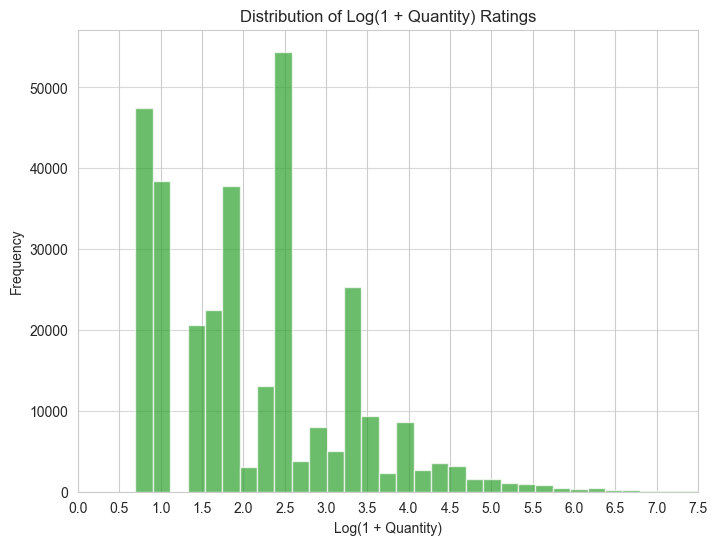

In [17]:
# Visualize the distribution of Quantity ratings in the training set
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df_quant_train['LogQuantity'], bins=50, color='tab:green', alpha=0.7)
plt.xlabel('Log(1 + Quantity)')
plt.ylabel('Frequency')
plt.title('Distribution of Log(1 + Quantity) Ratings')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 6)
plt.xticks(np.arange(0, 8, 0.5))
plt.show()

## SVD

### SVD Model Training

This step is aiming to find the best n_factors for SVD model. 
It may take a few minutes to train.    
If you only want to see the result, please run the function cell and jump to 'Calculating Final SVD Model'

In [18]:
import pandas as pd
import numpy as np
from surprise import SVD
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Helper Function: Get Top-K Recommendations ---

def get_top_k_recommendations(model, train_df, ground_truth, k=10):
    """
    Generates Top-K recommendations for users in the ground_truth.
    It ensures not to recommend items already bought in the training set.
    """
      
    # Get the set of all unique items from the training data
    all_items = train_df['StockCode'].unique()
    
    # Get the list of users we need to predict for (those in our "answer key")
    test_users = list(ground_truth.keys())
    
    # This will hold our final recommendations: {uid -> [top_k_items]}
    recommendations = defaultdict(list)
    
    for uid in test_users:
        
        # This will hold (predicted_rating, item_id) tuples
        user_predictions = []
        
        # Predict rating for all items 
        for iid in all_items:
            pred = model.predict(uid, iid)
            user_predictions.append((pred.est, pred.iid))
        
        # Sort predictions by highest rating
        user_predictions.sort(key=lambda x: x[0], reverse=True)
        
        # Get the Top-K item IDs
        top_k_items = [iid for (est, iid) in user_predictions[:k]]
        recommendations[uid] = top_k_items
        
    return recommendations

# --- Helper Function: Calculate Precision@k and Recall@k ---

def calculate_metrics(recommendations, ground_truth, k=10):
    """
    Calculates the average Precision@k and Recall@k for all users.
    """

    precisions = []
    recalls = []
    
    # Iterate over each user's recommendations
    for uid, recommended_items in recommendations.items():
        true_items = ground_truth.get(uid, set())
        
        # If there are no items in the ground truth, we can't evaluate
        if not true_items:
            continue
            
        # Find the number of "hits"
        hits = len(set(recommended_items) & true_items)
        
        # Calculate Precision@k
        p_at_k = hits / k
        precisions.append(p_at_k)
        
        # Calculate Recall@k
        r_at_k = hits / len(true_items)
        recalls.append(r_at_k)
        
    # Return the average precision and recall
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    
    return avg_precision, avg_recall

In [19]:
print("--- Starting SVD (Log Transform) Training and Evaluation Loop ---")
# --- Hyperparameter Tuning Loop (MODIFIED) ---
# We MUST use trainset_log_quant
if 'trainset_log_quant' not in locals() or 'ground_truth' not in locals() or 'train_df' not in locals():
    print("Error: 'trainset_log_quant', 'ground_truth', or 'train_df' is missing.")
else:
    # k=20 (for Top-20 list)
    K_RECOMMENDATIONS = 20

    # n_factors range (260 to 360, step 10)
    factors_range = range(260, 360, 10)
    
    results = []

    print(f"\nStarting loop for n_factors from {factors_range.start} to {factors_range.stop-1}...")
    
    for n in factors_range:
        print(f"\n--- Training SVD (LogQuant) with n_factors = {n} ---")
        
        # Initialize SVD model
        svd_model = SVD(
            n_factors=n, 
            n_epochs=40,       
            lr_all=0.01,       
            reg_all=0.001,     
            biased=False,      
            random_state=42, 
            verbose=False      
        )
        
        # Train the model on the (PAST) data
        svd_model.fit(trainset_log_quant) 
        
        # Generate Top-K recommendations
        recs = get_top_k_recommendations(svd_model, train_df, ground_truth, k=K_RECOMMENDATIONS)
        
        # Calculate P@20 and R@20
        p_at_k, r_at_k = calculate_metrics(recs, ground_truth, k=K_RECOMMENDATIONS)
        
        print(f"   Results for n_factors={n}: P@20 = {p_at_k:.4f}, R@20 = {r_at_k:.4f}")
        
        # Store results
        results.append({'n_factors': n, 'Precision@20': p_at_k, 'Recall@20': r_at_k})

    # Convert results to a DataFrame for easy plotting
    results_df = pd.DataFrame(results)
    results_df['Precision@20'] = (results_df['Precision@20'] * 100).round(2)
    results_df['Recall@20'] = (results_df['Recall@20'] * 100).round(2)


--- Starting SVD (Log Transform) Training and Evaluation Loop ---

Starting loop for n_factors from 260 to 359...

--- Training SVD (LogQuant) with n_factors = 260 ---
   Results for n_factors=260: P@20 = 0.1038, R@20 = 0.0727

--- Training SVD (LogQuant) with n_factors = 270 ---
   Results for n_factors=270: P@20 = 0.1038, R@20 = 0.0743

--- Training SVD (LogQuant) with n_factors = 280 ---
   Results for n_factors=280: P@20 = 0.1064, R@20 = 0.0758

--- Training SVD (LogQuant) with n_factors = 290 ---
   Results for n_factors=290: P@20 = 0.1091, R@20 = 0.0777

--- Training SVD (LogQuant) with n_factors = 300 ---
   Results for n_factors=300: P@20 = 0.1087, R@20 = 0.0775

--- Training SVD (LogQuant) with n_factors = 310 ---
   Results for n_factors=310: P@20 = 0.1083, R@20 = 0.0788

--- Training SVD (LogQuant) with n_factors = 320 ---
   Results for n_factors=320: P@20 = 0.1117, R@20 = 0.0803

--- Training SVD (LogQuant) with n_factors = 330 ---
   Results for n_factors=330: P@20 = 0.11

### Check and Visualize the Results


--- Final Evaluation Results ---
   n_factors  Precision@20  Recall@20
0        260         10.38       7.27
1        270         10.38       7.43
2        280         10.64       7.58
3        290         10.91       7.77
4        300         10.87       7.75
5        310         10.83       7.88
6        320         11.17       8.03
7        330         11.11       8.01
8        340         11.21       8.04
9        350         11.43       8.22

--- Plotting P@20 and R@20 vs. n_factors ---


<Figure size 1400x600 with 0 Axes>

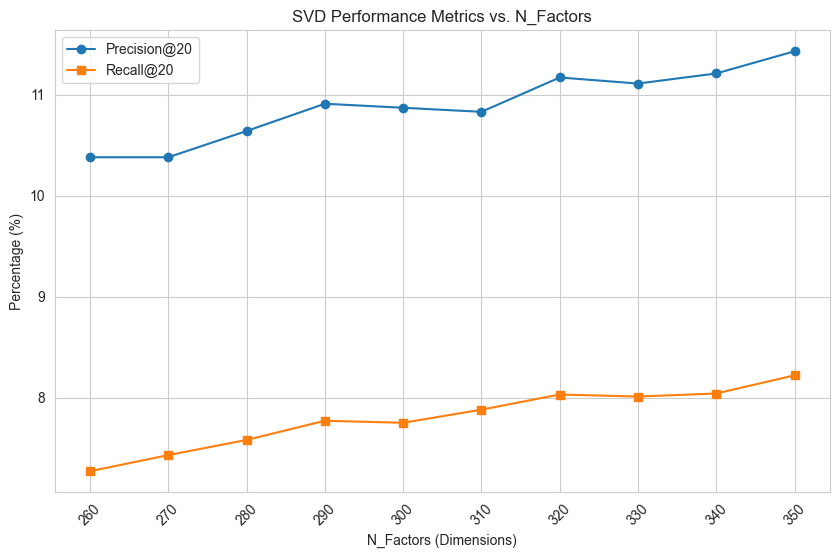

In [20]:
print("\n--- Final Evaluation Results ---")
print(results_df)

print("\n--- Plotting P@20 and R@20 vs. n_factors ---")
plt.figure(figsize=(14, 6))

# Visualize Precision@k and Recall@k distributions
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_factors'], results_df['Precision@20'], marker='o', label='Precision@20')
plt.plot(results_df['n_factors'], results_df['Recall@20'], marker='s', label='Recall@20')
plt.title('SVD Performance Metrics vs. N_Factors')
plt.xlabel('N_Factors (Dimensions)')
plt.ylabel('Percentage (%)')
plt.xticks(results_df['n_factors'], rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Based on the observed chart, we selected n_factor=320.

### Calculating Final SVD Model

In [21]:
# Based on our tuning, n_factors=200 provides the best balance
# of Precision@20 (2nd best) and Recall@20 (2nd best).
# We will now train the final model using these parameters.

from surprise import SVD

print("--- Training the Final SVD Model ---")

# --- Define Final Parameters ---
# As chosen from the tuning plots
OPTIMAL_N_FACTORS = 320
EPOCHS = 40
LEARN_RATE = 0.01
REGULARIZATION = 0.001
K_RECOMMENDATIONS = 20

# --- Check if Trainset Exists ---
if 'trainset_log_quant' not in locals():
    print("Error: 'trainset_log_quant' is missing.")
else:
    print(f"Using optimal parameters:")
    print(f"  n_factors: {OPTIMAL_N_FACTORS}")
    print(f"  n_epochs: {EPOCHS}")
    print(f"  lr_all: {LEARN_RATE}")
    print(f"  reg_all: {REGULARIZATION}")
    print(f"  biased: False")

    # --- 3. Initialize and Train Final Model ---
    print("\nTraining final SVD model on 'trainset_log_quant'...")
    
    # Initialize the SVD model with our chosen parameters
    svd_final = SVD(
        n_factors=OPTIMAL_N_FACTORS, 
        n_epochs=EPOCHS,       
        lr_all=LEARN_RATE,       
        reg_all=REGULARIZATION,     
        biased=False,      
        random_state=42, 
        verbose=True  
    )
    
    # Train the model on the full (PAST) log-quantity dataset
    svd_final.fit(trainset_log_quant)
    
    print("\n Final SVD model ('svd_final') is trained and ready!")

--- Training the Final SVD Model ---
Using optimal parameters:
  n_factors: 320
  n_epochs: 40
  lr_all: 0.01
  reg_all: 0.001
  biased: False

Training final SVD model on 'trainset_log_quant'...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39

 Final SVD mo

Using K_RECOMMENDATIONS = 20 (as set in your 'Final SVD Model' cell)
Generating recommendations for all test users (this may take a moment)...
   Calculating individual Precision and Recall scores...

Calculated metrics for 2246 users.
--- Score Statistics ---
mean: {'P@20': 0.1117319679430098, 'R@20': 0.08025366680478971}

--- Plotting Distributions ---


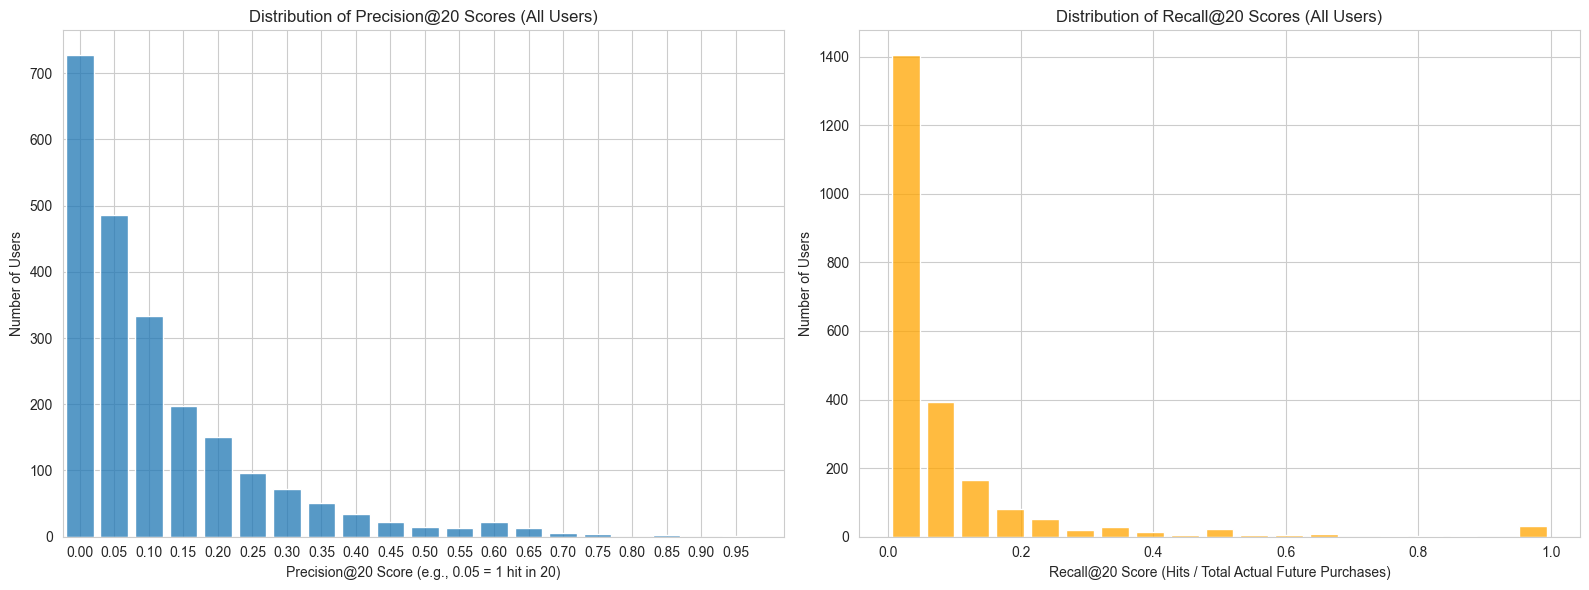

In [22]:
# --- Final Model Evaluation (Distribution Plots) ---
# This cell checks the performance of 'svd_final' on ALL users 
# in the test set and plots the distribution of scores.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# --- (NEW) Helper Function: Calculate INDIVIDUAL Metrics ---
# We need this new function to get lists of scores, not just the average.
def calculate_individual_metrics(recommendations, ground_truth, k=20):
    """
    Calculates P@k and R@k for EACH user and returns the lists.
    """
    print("   Calculating individual Precision and Recall scores...")
    precisions = []
    recalls = []
    
    # Iterate over each user's recommendations
    for uid, recommended_items in recommendations.items():
        true_items = ground_truth.get(uid, set())
        
        # If there are no items in the ground truth, we can't evaluate
        if not true_items:
            precisions.append(0.0)
            recalls.append(0.0)
            continue
            
        # Find the number of "hits"
        hits = len(set(recommended_items) & true_items)
        
        # Calculate Precision@k
        p_at_k = hits / k
        precisions.append(p_at_k)
        
        # Calculate Recall@k
        r_at_k = hits / len(true_items)
        recalls.append(r_at_k)
        
    return precisions, recalls

# --- Check for required variables & functions (using globals()) ---
# We check for the function 'get_top_k_recommendations' from the tuning cell (e.g., cell [151] or [153])
# and variables from the previous cells.
required_funcs_vars = ['get_top_k_recommendations', 'svd_final', 'train_df', 'ground_truth', 'K_RECOMMENDATIONS']

if not all(v in globals() for v in required_funcs_vars):
    print("Error: One or more required functions/variables are missing.")
    print("Please ensure 'Data Preparation' (V7), 'SVD Model Training' (Tuning Loop), and 'Final SVD Model' cells ran successfully.")
    print("Missing:", [v for v in required_funcs_vars if v not in globals()])
else:
    
    # --- Generate Recs and Calculate Metrics ---
    print(f"Using K_RECOMMENDATIONS = {K_RECOMMENDATIONS} (as set in your 'Final SVD Model' cell)")
    
    # 1. Generate recommendations for ALL test users
    # (This calls the 'get_top_k_recommendations' defined in your tuning loop cell)
    print("Generating recommendations for all test users (this may take a moment)...")
    all_recs = get_top_k_recommendations(svd_final, train_df, ground_truth, k=K_RECOMMENDATIONS)
    
    # 2. Calculate individual scores
    p20_scores, r20_scores = calculate_individual_metrics(all_recs, ground_truth, k=K_RECOMMENDATIONS)
    
    # Store in a DataFrame for easier plotting
    metrics_dist_df = pd.DataFrame({
        'P@20': p20_scores,
        'R@20': r20_scores
    })
    
    print(f"\nCalculated metrics for {len(metrics_dist_df)} users.")
    print("--- Score Statistics ---")
    print('mean:' , metrics_dist_df.mean().to_dict())

    # --- 5. Plotting the Distributions (Bar Plots/Histograms) ---
    print("\n--- Plotting Distributions ---")
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))

    # --- Plot Precision@20 Distribution ---
    plt.subplot(1, 2, 1)
    
    # We want discrete bars for P@20 (0/20, 1/20, 2/20...)
    # We create bins: -0.025, 0.025, 0.075, 0.125 ... (centered on 0.0, 0.05, 0.1...)
    # k=20, so 1/20 = 0.05
    bins_p = np.arange(-0.025, max(0.2, metrics_dist_df['P@20'].max()) + 0.05, 0.05) 
    
    sns.histplot(data=metrics_dist_df, x='P@20', bins=bins_p, kde=False, shrink=0.8)
    
    plt.title('Distribution of Precision@20 Scores (All Users)')
    plt.xlabel('Precision@20 Score (e.g., 0.05 = 1 hit in 20)')
    plt.ylabel('Number of Users')
    plt.xticks(np.arange(0, max(0.2, metrics_dist_df['P@20'].max()) + 0.05, 0.05))
    plt.xlim(left=-0.025)

    # --- Plot Recall@20 Distribution ---
    plt.subplot(1, 2, 2)
    
    # For Recall, scores are continuous (e.g., 1/3, 1/7, 1/19...), so we use 20 bins
    bins_r = np.linspace(0, max(0.1, metrics_dist_df['R@20'].max()), 20)
    
    sns.histplot(data=metrics_dist_df, x='R@20', bins=bins_r, kde=False, color='orange', shrink=0.8)
    
    plt.title('Distribution of Recall@20 Scores (All Users)')
    plt.xlabel('Recall@20 Score (Hits / Total Actual Future Purchases)')
    plt.ylabel('Number of Users')

    plt.tight_layout()
    plt.show()

### Test on a random example

In [23]:
import random

# --- 2. Create StockCode-to-Description Map ---
print("Creating StockCode-to-Description map...")
stock_desc_map = df_clean.drop_duplicates(subset=['StockCode']).set_index('StockCode')['Description'].to_dict()

# --- 3. Pick a Random User ---
random_user_id = random.choice(list(ground_truth.keys()))
print(f"👤 Random User Selected: {random_user_id}")

# --- 4. Get Top-K Recommendations for this user ---

# Get all unique items from the training data
all_items = train_df['StockCode'].unique()

# Predict ratings for ALL items
user_predictions = []
for iid in all_items:
    pred = svd_final.predict(random_user_id, iid)
    user_predictions.append((pred.est, pred.iid))
        
# Sort predictions by highest rating
user_predictions.sort(key=lambda x: x[0], reverse=True)

# Get the Top-K recommended item IDs
recommended_iids = [iid for (est, iid) in user_predictions[:K_RECOMMENDATIONS]]

# Get the descriptions for the recommended items
recommended_items_desc = [f"{iid} ({stock_desc_map.get(iid, 'N/A')})" for iid in recommended_iids]

# --- 5. Get Actual Purchases (Ground Truth) for this user ---
actual_iids = ground_truth.get(random_user_id, set())
actual_items_desc = [f"{iid} ({stock_desc_map.get(iid, 'N/A')})" for iid in actual_iids]

# --- 6. Calculate P@k and R@k for THIS USER ---
hits = len(set(recommended_iids) & actual_iids)

if not actual_iids:
    print("This user bought no items in the test set. Evaluation skipped.")
    p_at_k = 0
    r_at_k = 0
else:
    p_at_k = hits / K_RECOMMENDATIONS
    r_at_k = hits / len(actual_iids)

# --- 7. Display Results ---
print("\n=======================================================")
print(f"        RECOMMENDATION ANALYSIS (User: {random_user_id})")
print("=======================================================")

print(f"\n Recommended Top {K_RECOMMENDATIONS} Items (Predicted):")
for i, item_desc in enumerate(recommended_items_desc, 1):
    print(f"  {i}. {item_desc}")
    
print(f"\n Actual Items Bought in Future (Ground Truth):")
if not actual_items_desc:
    print("  (None)")
else:
    for i, item_desc in enumerate(actual_items_desc, 1):
        print(f"  {i}. {item_desc}")

print("\n-------------------------------------------------------")
print(f"                   METRICS FOR THIS USER")
print("-------------------------------------------------------")
print(f"Hits (Recommended items that were actually bought): {hits}")
print(f"Precision@{K_RECOMMENDATIONS} (Hits / K): {hits} / {K_RECOMMENDATIONS} = {p_at_k:.2%}")
print(f"Recall@{K_RECOMMENDATIONS} (Hits / Actual): {hits} / {len(actual_iids)} = {r_at_k:.2%}")
print("=======================================================")

Creating StockCode-to-Description map...
👤 Random User Selected: 12994

        RECOMMENDATION ANALYSIS (User: 12994)

 Recommended Top 20 Items (Predicted):
  1. 84077 (WORLD WAR 2 GLIDERS ASSTD DESIGNS)
  2. 22558 (CLOTHES PEGS RETROSPOT PACK 24 )
  3. 21498 (RED SPOTS  WRAP )
  4. 16161P (WRAP ENGLISH ROSE )
  5. 85175 (CACTI T-LIGHT CANDLES)
  6. 84270 (ASSTD DESIGN BUBBLE GUM RING)
  7. 35957 (SMALLFOLKART BAUBLE CHRISTMAS DEC)
  8. 22740 (POLKA DOT PEN)
  9. 84568 (GIRLS ALPHABET IRON ON PATCHES )
  10. 84598 (BOYS ALPHABET IRON ON PATCHES)
  11. 84755 (COLOUR GLASS T-LIGHT HOLDER HANGING)
  12. 84970S (HANGING HEART ZINC T-LIGHT HOLDER)
  13. 85099B (JUMBO BAG RED WHITE SPOTTY )
  14. 22693 (GROW A FLYTRAP OR SUNFLOWER IN TIN)
  15. 22710 (WRAP I LOVE LONDON )
  16. 21977 (PACK OF 60 PINK PAISLEY CAKE CASES)
  17. 84670 (JAPANESE CROCHETED ANIMAL)
  18. 22151 (PLACE SETTING WHITE HEART)
  19. 84970L (SINGLE HEART ZINC T-LIGHT HOLDER)
  20. 21829 (DINOSAUR KEYRINGS ASSORTED)

 Ac

### An Example
Creating StockCode-to-Description map...  
👤 Random User Selected: 14745



 Recommended Top 20 Items (Predicted):
  1. 84598 (BOYS ALPHABET IRON ON PATCHES)
  2. 84568 (GIRLS ALPHABET IRON ON PATCHES )
  3. 21868 (POTTING SHED TEA MUG)
  4. 84077 (WORLD WAR 2 GLIDERS ASSTD DESIGNS)
  5. 85175 (CACTI T-LIGHT CANDLES)
  6. 84971S (SMALL HEART FLOWERS HOOK )
  7. 16033 (MINI HIGHLIGHTER PENS)
  8. 22528 (GARDENERS KNEELING PAD)
  9. 84270 (ASSTD DESIGN BUBBLE GUM RING)
  10. 22710 (WRAP I LOVE LONDON )
  11. 22492 (MINI PAINT SET VINTAGE )
  12. 20728 (LUNCH BAG CARS BLUE)
  13. 22384 (LUNCHBAG PINK RETROSPOT)
  14. 84945 (MULTI COLOUR SILVER T-LIGHT HOLDER)
  15. 21829 (DINOSAUR KEYRINGS ASSORTED)
  16. 84670 (JAPANESE CROCHETED ANIMAL)
  17. 16259 (PIECE OF CAMO STATIONERY SET)
...  
Hits (Recommended items that were actually bought): 5  
Precision@20 (Hits / K): 5 / 20 = 25.00%  
Recall@20 (Hits / Actual): 5 / 30 = 16.67%

## A-priori

In [24]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

print("--- Starting Market Basket Analysis ---")

# ==========================================
# 1. 数据准备 (Data Preparation)
# ==========================================
# 假设 df_clean 是你已经清洗好的大表
# 过滤掉退货 (C开头的) 和 邮费 (POST) - 虽然前面应该洗过了，再保险一次
df_basket = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
df_basket = df_basket[df_basket['StockCode'] != 'POST']

# 为了防止内存爆炸，且为了更有商业意义，我们只分析 Top 1000 热销商品
# 逻辑：长尾商品(一年才卖一次的)对制定捆绑策略没意义
top_items = df_basket['Description'].value_counts().head(1000).index
df_basket = df_basket[df_basket['Description'].isin(top_items)]

# 建议：只取一个国家的数据跑，比如 'United Kingdom'，否则不同国家的消费习惯混在一起会产生噪音
# 如果你的数据里大部分是 UK，这一步可以省略，或者保留
df_basket = df_basket[df_basket['Country'] == 'United Kingdom']

print(f"Data filtered. Analyzing {len(df_basket)} transactions for Top 1000 items.")

# ==========================================
# 2. 构建购物篮矩阵 (One-Hot Encoding)
# ==========================================
# 这是一个极其消耗内存的操作: 行=订单, 列=商品
# 我们用 unstack 方式快速转换
basket = (df_basket.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

# 把数量转为 0/1 (买了/没买)
# 使用矢量化操作替代 astype，兼容性更好且速度更快
basket_sets = (basket >= 1).astype(int)
print("Basket Matrix created successfully.")

# ==========================================
# 3. 挖掘关联规则 (Apriori Algorithm)
# ==========================================
print("Running Apriori Algorithm... (This might take a minute)")
# min_support=0.02: 至少有 2% 的订单里出现的组合才算。如果跑不出结果，把这个数调小 (比如 0.01)
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

if frequent_itemsets.empty:
    print("⚠️ 警告: 没有找到满足条件的商品组合！请尝试调低 min_support (例如改为 0.01)")
else:
    # 计算关联指标
    # min_threshold=1: 只保留 Lift > 1 的 (正相关)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    # ==========================================
    # 4. 整理并导出
    # ==========================================
    # 整理列名，方便 Power BI 识别
    # antecedents (前项) -> consequents (后项)
    rules['Item_A'] = rules['antecedents'].apply(lambda x: list(x)[0])
    rules['Item_B'] = rules['consequents'].apply(lambda x: list(x)[0])

    # 筛选核心列
    rules_final = rules[['Item_A', 'Item_B', 'support', 'confidence', 'lift']]
    
    # 排序：按提升度 (Lift) 倒序，把最强的 CP 排前面
    rules_final = rules_final.sort_values('lift', ascending=False)

    # 导出
    output_path = os.path.join('..', 'data', 'product_rules_for_pbi.csv')
    rules_final.to_csv(output_path, index=False)
    print(f"\n✅ 购物篮分析完成！找到 {len(rules_final)} 条关联规则。")
    print(f"文件已生成: {output_path}")
    print(rules_final.head())

--- Starting Market Basket Analysis ---
Data filtered. Analyzing 433124 transactions for Top 1000 items.
Basket Matrix created successfully.
Running Apriori Algorithm... (This might take a minute)


d:\Programs\anaconda3\envs\tf_env\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



✅ 购物篮分析完成！找到 46 条关联规则。
文件已生成: ..\data\product_rules_for_pbi.csv
                              Item_A                            Item_B  \
6    GREEN REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER    
7   ROSES REGENCY TEACUP AND SAUCER    GREEN REGENCY TEACUP AND SAUCER   
2         ALARM CLOCK BAKELIKE GREEN         ALARM CLOCK BAKELIKE RED    
3          ALARM CLOCK BAKELIKE RED         ALARM CLOCK BAKELIKE GREEN   
39    SWEETHEART CERAMIC TRINKET BOX    STRAWBERRY CERAMIC TRINKET BOX   

     support  confidence       lift  
6   0.020970    0.807437  27.770849  
7   0.020970    0.721234  27.770849  
2   0.020177    0.664018  20.308589  
3   0.020177    0.617089  20.308589  
39  0.024384    0.696552  13.054829  
